In [1]:
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt
from visualize import *
from calibration import *
import torch
import GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import normalize
numpy.random.seed(0x5eed)
import warnings
warnings.filterwarnings("ignore")
% matplotlib inline
%config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
#import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

In [2]:
def gmm_sample(n, weights, norm_params, plot=False):
    """
    This function draws n samples from Gaussian mixture models parametrized by weights and 
    norm_params. Plot can only be turned on in one dimensional case.
    INPUT:
        n: An int. The number of samples to draw.
        weights: np.array (num_components,). Weights of each component.
        norm_params:
        plot: Boolean. If True, theretical PDF of the GMM and histogram of data will be plotted.
    OUTPUT:
        y: np.array (n, ). Samples drawn from GMM.
        mixture_idx: np.array (n, ). True label of each sample.
    """
    assert weights.shape[0] == norm_params.shape[0]
    assert norm_params.shape[1] == 2
    assert weights.sum() == 1.0
    assert weights.all() > 0
    if plot == True:
        assert norm_params[0,0].shape  == ()
    n_components = norm_params.shape[0]
    # Weight of each component, in this case all of them are 1/3
    # A stream of indices from which to choose the component
    mixture_idx = np.random.choice(n_components, size=n, replace=True, p=weights)
    # y is the mixture sample
    y = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                       dtype=np.float64)
    if plot:
        # Theoretical PDF plotting -- generate the x and y plotting positions
        xs = np.linspace(y.min(), y.max(), 200)
        ys = np.zeros_like(xs)

        for (l, s), w in zip(norm_params, weights):
            ys += ss.norm.pdf(xs, loc=l, scale=s) * w

        plt.plot(xs, ys)
        plt.hist(y, normed=True, bins="fd")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.show()
    return y, mixture_idx

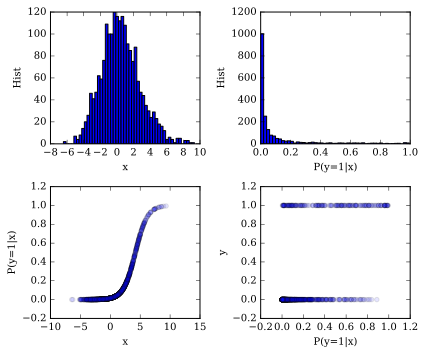

In [3]:
# generate simulation data
n = 2000
norm_params = np.array([[0, 2],
                        [4, 2]])
weights = np.array([0.9, 0.1])
x, y = gmm_sample(n, weights, norm_params) # (n, 1)
# compute posterior
# theta: np.array(n_components, n_samples). Each entry is P(x_i | component k) * weight_k
# posterior: np.array(n_samples, ). Each entry is f_x = P(y = 1|x).
theta = []
for (l, s), w in zip(norm_params, weights):
    theta.append(ss.norm.pdf(x, loc=l, scale=s) * w)
theta = np.array(theta)
f_x = theta[1]/(theta[0] + theta[1])

# plot the histogram of posterior
plt.figure(figsize=(6,5))
plt.subplot(2, 2, 1); plt.hist(x, bins=50)
plt.xlabel("x"); plt.ylabel("Hist")
plt.subplot(2, 2, 2); plt.hist(f_x, bins=50)
plt.xlabel("P(y=1|x)"); plt.ylabel("Hist")
plt.subplot(2, 2, 3); plt.scatter(x, f_x, alpha=0.1)
plt.xlabel("x"); plt.ylabel("P(y=1|x)")
plt.subplot(2, 2, 4); plt.scatter(f_x, y, alpha=0.1)
plt.xlabel("P(y=1|x)"); plt.ylabel("y")
plt.tight_layout()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
set([1, 2, 4, 7, 8, 9, 11])


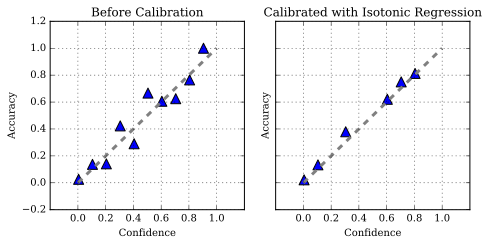

In [4]:
p_calibrated = isotonic_calibration(np.array([1-f_x, f_x]).T, 
                                    y, 
                                    np.array([1-f_x, f_x]).T)

NUM_BINS = 10
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = (7, 3.5))
axs[0] = reliability_plot_binary(axs[0], f_x, y, NUM_BINS)[-1]
axs[1] = reliability_plot_binary(axs[1], p_calibrated[:,-1], y, NUM_BINS)[-1]
axs[0].set_title("Before Calibration")
axs[1].set_title("Calibrated with Isotonic Regression")
fig.tight_layout()

(2000,)
CPU times: user 1min 43s, sys: 1min 56s, total: 3min 40s
Wall time: 52.7 s


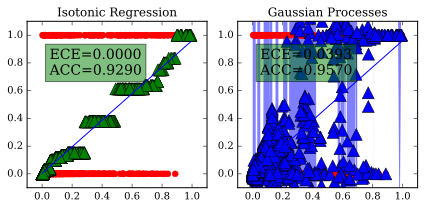

In [5]:
%%time
f, ax = plt.subplots(1,2)
f.set_figheight(3)
f.set_figwidth(6)
ax[0] = isotonic_regression(ax[0],f_x,y)
ax[1] = gp_regression(ax[1],f_x,y)
ax[0].set_title("Isotonic Regression")
ax[1].set_title("Gaussian Processes")
f.tight_layout()


Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=0.01)

Learned kernel: 1**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1)

Learned kernel: 1**2 * RBF(length_scale=0.01) + 10**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=0.1)

Learned kernel: 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=1)

Learned kernel: 1**2 * RBF(length_scale=0.1) + 10**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=0.5)

Learned kernel: 1**2 * RBF(length_scale=0.5) + WhiteKernel(noise_level=1)

Learned kernel: 1**2 * RBF(length_scale=0.5) + 10**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)

Learned kernel: 1**2 * RBF(length_scale=1) + 10**2 * RBF(length_scale=1)
CPU times: user 44min 3s, sys: 37min 15

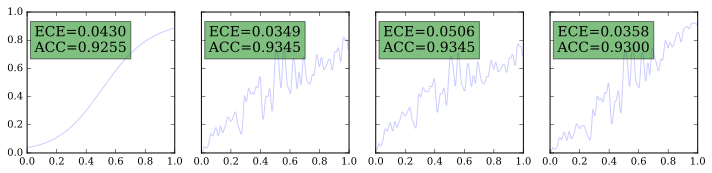

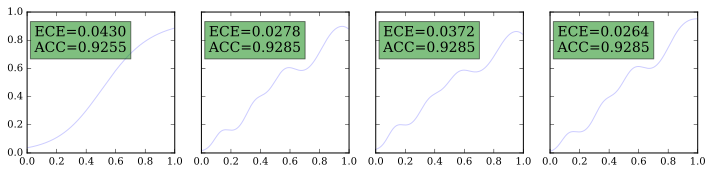

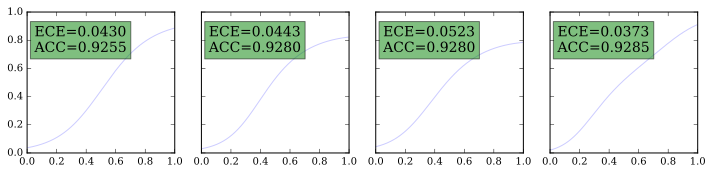

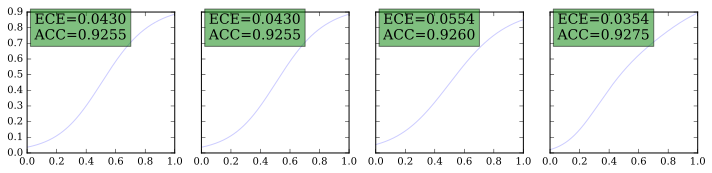

In [6]:
%%time
# GPC with sklearn
RBF_SCALES = [0.01, 0.1, 0.5, 1.0]
#RBF_SCALE = 0.5
for RBF_SCALE in RBF_SCALES:
    KERNELS = [None,
               1 ** 2 * RBF(RBF_SCALE, (0.05, 1)), 
               1 ** 2 * RBF(RBF_SCALE, (0.05, 1)) + WhiteKernel(noise_level = 1.0),
               1 ** 2 * RBF(RBF_SCALE, (0.05, 1)) + 10**2 * RBF(1)]
    f, ax = plt.subplots(1, 4, sharex='col', sharey='row')
    f.set_figheight(2.5)
    f.set_figwidth(10)
    for i in range(len(KERNELS)):
        kernel = KERNELS[i]
        ax[i] = gpc_sklearn(ax[i],f_x,y,kernel,optimizer=None)
    f.tight_layout()

In [7]:
# %%time
# # GPC with GPy
# KERNELS = [None, 
#            GPy.kern.RBF(1,variance=5.,lengthscale=0.1) + GPy.kern.Linear(1)]
# f, ax = plt.subplots(1, 2, sharex='col', sharey='row')
# f.set_figheight(3)
# f.set_figwidth(6)
# for i in range(len(KERNELS)):
#     kernel = KERNELS[i]
#     ax[i] = gpc_gpy(ax[i],f_x,y,kernel)
# f.tight_layout()

# Distort the output probability

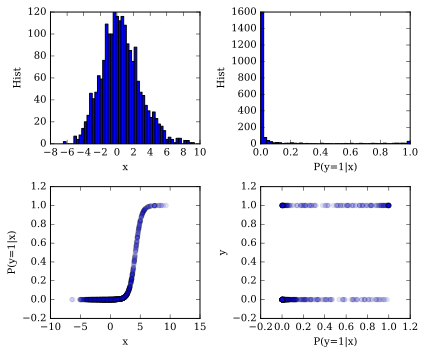

In [8]:
# generate simulation data
ALPHA = 2.0
p = np.array([1-f_x, f_x])
p_distort = p ** ALPHA
# make sure ACC does not change after distortion in the binary case 
# by centering the transformatio at 0.5
f_x_distort = p_distort[1]/(p_distort[0] + p_distort[1])

# plot the histogram of posterior
plt.figure(figsize=(6,5))
plt.subplot(2, 2, 1); plt.hist(x, bins=50)
plt.xlabel("x"); plt.ylabel("Hist")
plt.subplot(2, 2, 2); plt.hist(f_x_distort, bins=50)
plt.xlabel("P(y=1|x)"); plt.ylabel("Hist")
plt.subplot(2, 2, 3); plt.scatter(x, f_x_distort, alpha=0.1)
plt.xlabel("x"); plt.ylabel("P(y=1|x)")
plt.subplot(2, 2, 4); plt.scatter(f_x_distort, y, alpha=0.1)
plt.xlabel("P(y=1|x)"); plt.ylabel("y")

plt.tight_layout()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
set([1, 2, 4, 7, 8, 9, 11])


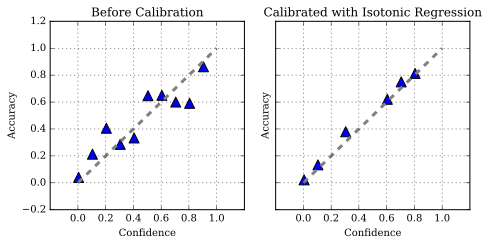

In [9]:
p_calibrated = isotonic_calibration(np.array([1-f_x_distort, f_x_distort]).T, 
                                    y, 
                                    np.array([1-f_x_distort, f_x_distort]).T)

NUM_BINS = 10
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = (7, 3.5))
axs[0] = reliability_plot_binary(axs[0], f_x_distort, y, NUM_BINS)[-1]
axs[1] = reliability_plot_binary(axs[1], p_calibrated[:,-1], y, NUM_BINS)[-1]
axs[0].set_title("Before Calibration")
axs[1].set_title("Calibrated with Isotonic Regression")
fig.tight_layout()

(2000,)
CPU times: user 1min 49s, sys: 2min 21s, total: 4min 11s
Wall time: 52.5 s


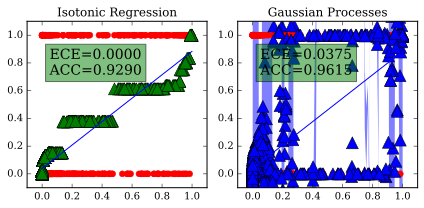

In [10]:
%%time
# fit GP to P(y=1|x) vs. y. (Subfigure 4)
f, ax = plt.subplots(1,2)
f.set_figheight(3)
f.set_figwidth(6)
ax[0] = isotonic_regression(ax[0],f_x_distort,y)
ax[1] = gp_regression(ax[1],f_x_distort,y)
ax[0].set_title("Isotonic Regression")
ax[1].set_title("Gaussian Processes")
f.tight_layout()


Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=0.01)

Learned kernel: 1**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=1)

Learned kernel: 1**2 * RBF(length_scale=0.01) + 10**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=0.1)

Learned kernel: 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=1)

Learned kernel: 1**2 * RBF(length_scale=0.1) + 10**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=0.5)

Learned kernel: 1**2 * RBF(length_scale=0.5) + WhiteKernel(noise_level=1)

Learned kernel: 1**2 * RBF(length_scale=0.5) + 10**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1)

Learned kernel: 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)

Learned kernel: 1**2 * RBF(length_scale=1) + 10**2 * RBF(length_scale=1)
CPU times: user 38min 45s, sys: 33min 4

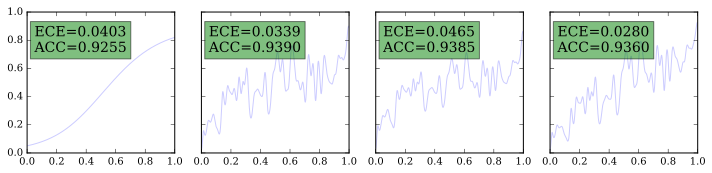

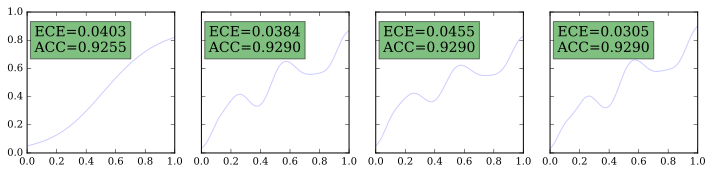

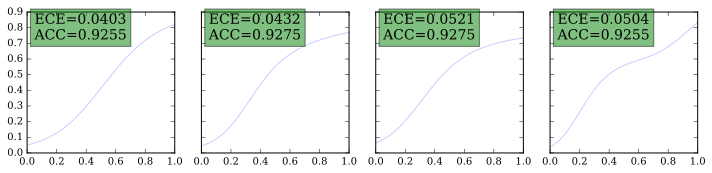

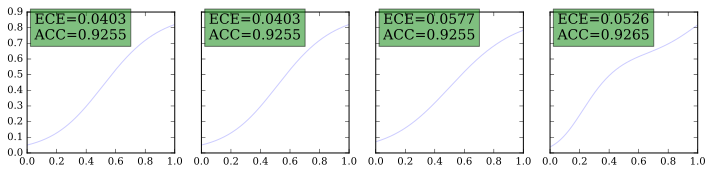

In [11]:
%%time
# GPC with sklearn
RBF_SCALES = [0.01, 0.1, 0.5, 1.0]
RBF_SCALE = 0.5
for RBF_SCALE in RBF_SCALES:
    KERNELS = [None,
               1 ** 2 * RBF(RBF_SCALE, (0.05, 1)), 
               1 ** 2 * RBF(RBF_SCALE, (0.05, 1)) + WhiteKernel(noise_level = 1.0),
               1 ** 2 * RBF(RBF_SCALE, (0.05, 1)) + 10**2 * RBF(1)]
    f, ax = plt.subplots(1, 4, sharex='col', sharey='row')
    f.set_figheight(2.5)
    f.set_figwidth(10)
    for i in range(len(KERNELS)):
        kernel = KERNELS[i]
        ax[i] = gpc_sklearn(ax[i],f_x_distort,y,kernel, optimizer=None)
    f.tight_layout()

In [12]:
# %%time
# KERNELS = [None, 
#            GPy.kern.RBF(1,variance=5.,lengthscale=0.1) + GPy.kern.Linear(1)]
# f, ax = plt.subplots(1, 2, sharex='col', sharey='row')
# f.set_figheight(3)
# f.set_figwidth(6)
# for i in range(len(KERNELS)):
#     kernel = KERNELS[i]
#     ax[i] = gpc_gpy(ax[i],f_x_distort,y,kernel)
# f.tight_layout()